# CAPP 30255 Final Project
## BERT Model
### Piper Kurtz, Wesley Janson, Sam Pavlekovsky

In [1]:
#Installations in case not there
! pip install transformers datasets evaluate
! pip uninstall -y transformers accelerate
! pip install transformers accelerate
! pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
# Import relevant packages
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
 

In [3]:
#Download BERT base
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [4]:
# from google.colab import drive 
# drive.mount('/content/gdrive')
# PATH = "gdrive/MyDrive/Colab Notebooks/"


def load_data(csv):
  # Reads the raw csv file and split into
  # sentences (x) and target (y)
  df = pd.read_csv(csv)  
  return df
# data = load_data(f'{PATH}/data.csv')
data = load_data(f'data/data.csv')
data=data.rename(columns = {'type':'labels'})
# rand_rows = np.random.randint(0,len(data),10000)
# data = data.iloc[rand_rows,:]
print(data)

Mounted at /content/gdrive
                                                      url              title  \
57401        https://en.wikipedia.org/wiki/Tropodiaptomus     Tropodiaptomus   
248391   https://en.wikipedia.org/wiki/Viscount%20Chandos   Viscount Chandos   
45005          https://en.wikipedia.org/wiki/Drew%20Olson         Drew Olson   
250155  https://en.wikipedia.org/wiki/Richard%20Linklater  Richard Linklater   
117815   https://en.wikipedia.org/wiki/Lancelot%20Volders   Lancelot Volders   
...                                                   ...                ...   
216044      https://en.wikipedia.org/wiki/North%20Britain      North Britain   
212862    https://en.wikipedia.org/wiki/Mexican%20vihuela    Mexican vihuela   
4558              https://en.wikipedia.org/wiki/BrainDead          BrainDead   
11095   https://en.wikipedia.org/wiki/Line%20%28given%...  Line (given name)   
196355      https://en.wikipedia.org/wiki/Shawn%20Stasiak      Shawn Stasiak   

            

In [5]:
#Tokenize inputs
def preprocess_function(examples):
    return tokenizer(examples["intro"], truncation=True)

In [6]:
#Create huggingface dataset style object
train, validate, test = np.split(data.sample(frac=1, random_state=42), 
                                 [int(.6*len(data)), int(.8*len(data))])

# Convert DataFrames to Dataset objects
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)
test_dataset = Dataset.from_pandas(test)

# Apply tokenization to the datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
#Create data collator for feeding into model
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [8]:
accuracy_metric = load_metric('accuracy')
precision_metric = load_metric('precision')
recall_metric = load_metric('recall')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels)
    recall = recall_metric.compute(predictions=predictions, references=labels)
    
    return {
        'accuracy': accuracy["accuracy"],
        'precision': precision["precision"],
        'recall': recall["recall"],
        'Type I Error': 1 - precision["precision"],  # Type I error is equivalent to (1 - Precision)
        'Type II Error': 1 - recall["recall"],  # Type II error is equivalent to (1 - Recall)
    }


<ipython-input-8-2e13e1a27ccb>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric('accuracy')


In [9]:
#Establish label dictionaries 
id2label = {0: "HUMAN", 1: "MACHINE"}
label2id = {"HUMAN": 0, "MACHINE": 1}

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)
training_args = TrainingArguments(
    output_dir="output",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,  # use the validation dataset for evaluation
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()




Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Type i error,Type ii error
1,No log,0.093987,0.972500,0.954797,0.994236,0.045203,0.005764
2,0.150800,0.307918,0.940000,0.896641,1.000000,0.103359,0.000000
3,0.022600,0.308258,0.950000,0.912358,1.000000,0.087642,0.000000
4,0.003700,0.144499,0.975500,0.955046,1.000000,0.044954,0.000000
5,0.003700,0.289335,0.955000,0.920424,1.000000,0.079576,0.000000


TrainOutput(global_step=1875, training_loss=0.04724751706520716, metrics={'train_runtime': 1165.8624, 'train_samples_per_second': 25.732, 'train_steps_per_second': 1.608, 'total_flos': 2849518631307840.0, 'train_loss': 0.04724751706520716, 'epoch': 5.0})

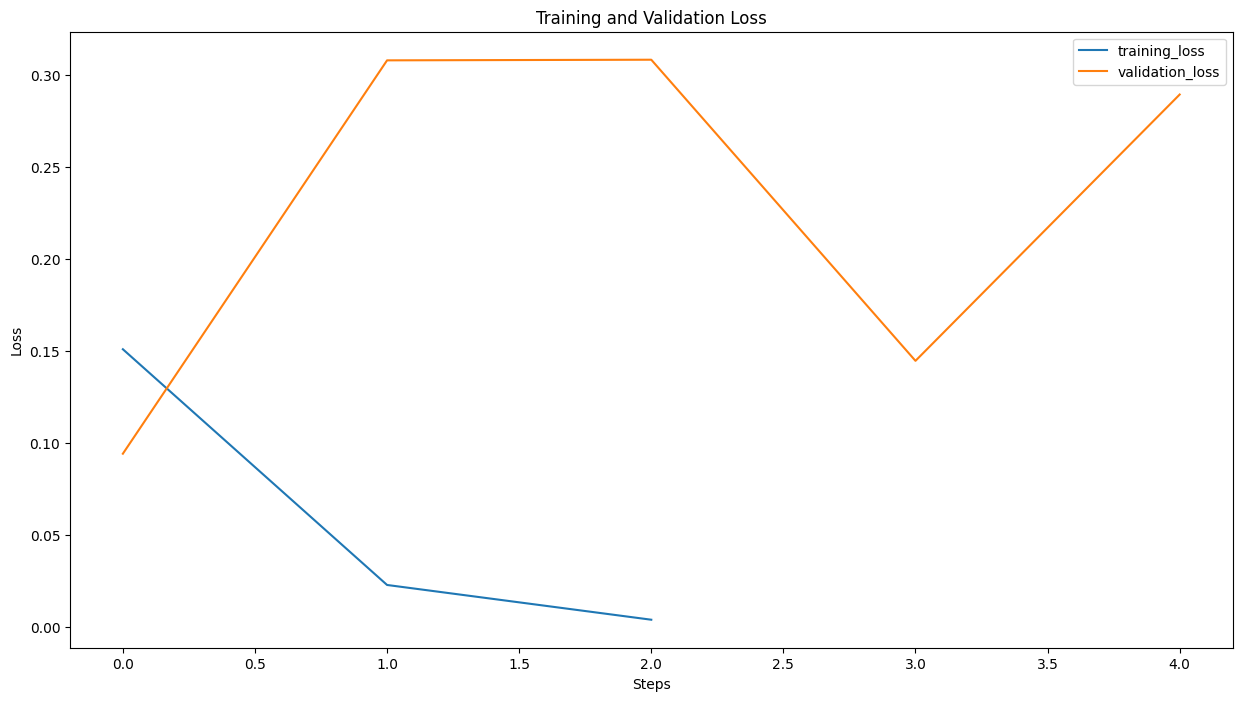

In [11]:
# get the training and validation loss and accuracy values from the trainer object
history = trainer.state.log_history
train_losses = [entry['loss'] for entry in history if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]


# Plot training and validation loss over time
plt.figure(figsize=(15,8))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="training_loss")
plt.plot(eval_losses,label="validation_loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


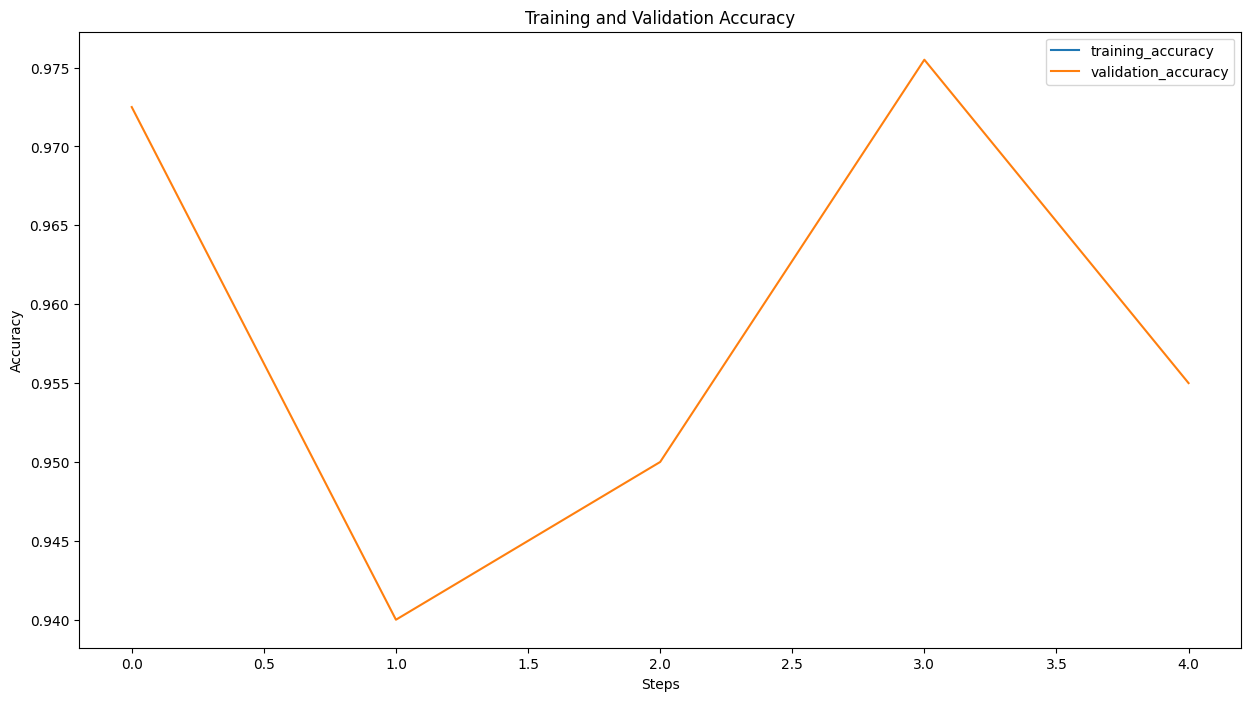

In [12]:
train_accuracies = [entry['accuracy'] for entry in history if 'accuracy' in entry]
eval_accuracies = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry]

# Plot training and validation accuracy over time
plt.figure(figsize=(15,8))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="training_accuracy")
plt.plot(eval_accuracies, label="validation_accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


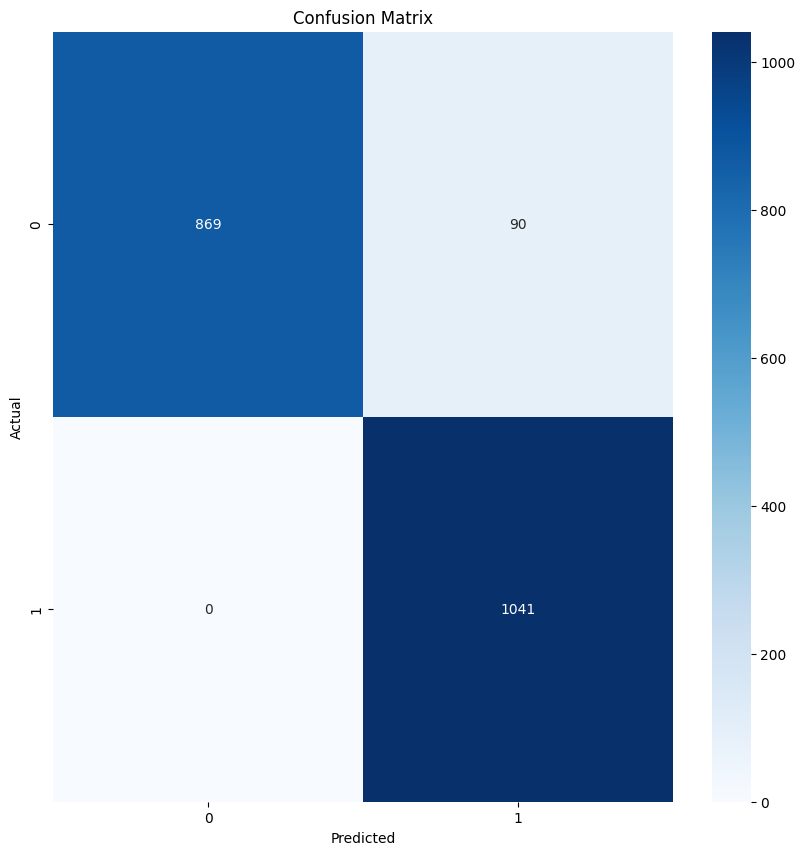

In [18]:
# Make predictions on validation set
predictions = trainer.predict(tokenized_val)
# The Trainer hides the columns that are not used by the model 
# (here 'labels' because it was not used when creating the dataset), 
# so we set them again

# Compute the confusion matrix
cm = confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=-1))

# Plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [16]:
# Evaluate the model on the test set
test_results = trainer.evaluate(tokenized_test)

print(f'Final performance on test set: {test_results}')

Final performance on test set: {'eval_loss': 0.2752963900566101, 'eval_accuracy': 0.9545, 'eval_precision': 0.9194991055456172, 'eval_recall': 0.9990281827016521, 'eval_Type I Error': 0.0805008944543828, 'eval_Type II Error': 0.0009718172983479434, 'eval_runtime': 27.1847, 'eval_samples_per_second': 73.571, 'eval_steps_per_second': 4.598, 'epoch': 5.0}
